# ModelList (Multi-Output) GP Regression

## Introduction

This notebook demonstrates how to wrap independent GP models into a convenient Multi-Output GP model using a ModelList. 

Unlike in the Multitask case, this do not model correlations between outcomes, but treats outcomes independently. This is equivalent to setting up a separate GP for each outcome, but can be much more convenient to handle, in particular it does not require manually looping over models when fitting or predicting.

This type of model is useful if 
- when the number of training / test points is different for the different outcomes
- using different covariance modules and / or likelihoods for each outcome

For block designs (i.e. when the above points do not apply), you should instead use a batch mode GP as described in the [batch simple regression example](../01_Simple_GP_Regression/Simple_Batch_Mode_GP_Regression.ipynb). This will be much faster because it uses additional parallelism.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using a different number of training examples for the different GPs.

In [2]:
train_x1 = torch.linspace(0, 0.95, 50) + 0.05 * torch.rand(50)
train_x2 = torch.linspace(0, 0.95, 25) + 0.05 * torch.rand(25)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x1)
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + 0.2 * torch.randn_like(train_x2)

## Set up the sub-models

Each individual model uses the `ExactGP` model from the [simple regression example](../01_Simple_GP_Regression/Simple_GP_Regression.ipynb).

In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
model1 = ExactGPModel(train_x1, train_y1, likelihood1)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
model2 = ExactGPModel(train_x2, train_y2, likelihood2)

We now collect the submodels in an `IndependentMultiOutputGP`, and the respective likelihoods in a `MultiOutputLikelihood`. These are container modules that make it easy to work with multiple outputs. In particular, they will take in and return lists of inputs / outputs and delegate the data to / from the appropriate sub-model (it is important that the order of the inputs / outputs corresponds to the order of models with which the containers were instantiated).

In [4]:
model = gpytorch.models.IndependentModelList(model1, model2)
likelihood = gpytorch.likelihoods.LikelihoodList(model1.likelihood, model2.likelihood)

### Set up overall Marginal Log Likelihood

Assuming independence, the MLL for the container model is simply the sum of the MLLs for the individual models. `SumMarginalLogLikelihood` is a convenient container for this (by default it uses an `ExactMarginalLogLikelihood` for each submodel)

In [5]:
from gpytorch.mlls import SumMarginalLogLikelihood

mll = SumMarginalLogLikelihood(likelihood, model)

## Train the model hyperparameters

With the containers in place, the models can be trained in a single loop on the container (note that this means that optimization is performed jointly, which can be an issue if the individual submodels require training via very different step sizes).

In [6]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes all submodel and all likelihood parameters
], lr=0.1)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(*model.train_inputs)
    loss = -mll(output, model.train_targets)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.052
Iter 2/50 - Loss: 1.020
Iter 3/50 - Loss: 0.983
Iter 4/50 - Loss: 0.942
Iter 5/50 - Loss: 0.898
Iter 6/50 - Loss: 0.851
Iter 7/50 - Loss: 0.803
Iter 8/50 - Loss: 0.754
Iter 9/50 - Loss: 0.707
Iter 10/50 - Loss: 0.663
Iter 11/50 - Loss: 0.624
Iter 12/50 - Loss: 0.589
Iter 13/50 - Loss: 0.557
Iter 14/50 - Loss: 0.523
Iter 15/50 - Loss: 0.493
Iter 16/50 - Loss: 0.460
Iter 17/50 - Loss: 0.424
Iter 18/50 - Loss: 0.395
Iter 19/50 - Loss: 0.362
Iter 20/50 - Loss: 0.331
Iter 21/50 - Loss: 0.304
Iter 22/50 - Loss: 0.261
Iter 23/50 - Loss: 0.231
Iter 24/50 - Loss: 0.202
Iter 25/50 - Loss: 0.182
Iter 26/50 - Loss: 0.153
Iter 27/50 - Loss: 0.138
Iter 28/50 - Loss: 0.121
Iter 29/50 - Loss: 0.104
Iter 30/50 - Loss: 0.092
Iter 31/50 - Loss: 0.078
Iter 32/50 - Loss: 0.067
Iter 33/50 - Loss: 0.058
Iter 34/50 - Loss: 0.060
Iter 35/50 - Loss: 0.046
Iter 36/50 - Loss: 0.055
Iter 37/50 - Loss: 0.046
Iter 38/50 - Loss: 0.053
Iter 39/50 - Loss: 0.063
Iter 40/50 - Loss: 0.059
Iter 41/5

## Make predictions with the model

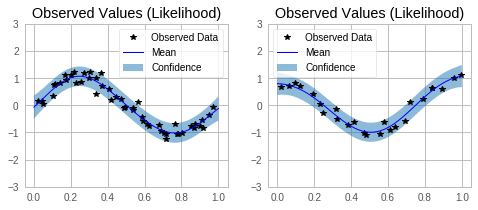

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, axs = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions (use the same test points)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    # This contains predictions for both outcomes as a list
    predictions = likelihood(*model(test_x, test_x))
    
for submodel, prediction, ax in zip(model.models, predictions, axs):
    mean = prediction.mean
    lower, upper = prediction.confidence_region()
    
    tr_x = submodel.train_inputs[0].detach().numpy()
    tr_y = submodel.train_targets.detach().numpy()
    
    # Plot training data as black stars
    ax.plot(tr_x, tr_y, 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title('Observed Values (Likelihood)')

None